# Proyecto Final
# Implementación de ODEs Neuronales para la Dinámica de una Grúa



## Introducción a las  _Neural ODEs_

El método Neural ODEs utiliza una red neuronal para determinar los parámetros óptimos que describen la dinámica de un sistema mediante la ecuación diferencial:

$$\frac{d\mathbf{z}}{dt} = f(\mathbf{z}(t),t,\mathbf{\theta})$$

dónde $f$ es implementada mediante una red neuronal y $\mathbf{z}$ es el estado del sistema. En [1] se presenta un método para realizar la retropropagación a través de un *solver* de ecuaciones diferenciales mediante el método de Pontryagin de estados adjuntos. Fundamentalmente si consideramos una función de costo de la forma:
$$ L(\mathbf{z}(t_f)) = L(\mathbf{z}(t_0)+\int_{t_0}^{t_f} f(\mathbf{z}(t),t,\mathbf{\theta}) dt) $$
Y definimos el estado adjunto $a(t)$:
$$ a(t) = \frac{\partial L}{\partial \mathbf{z}(t)} $$
desde luego:
$$ a(t_f) = \frac{dL}{dz} $$
El Teorema del Estado Adjunto (una deducción sencilla se proporciona en [1]) indica que
 la evolución del estado adjunto queda dada por:
$$ \frac{d}{dt}a(t) =-a(t) \frac{df}{d\theta}(\mathbf{z}(t),t,\theta) $$
Podemos obtener esta derivada en el estado inicial $\mathbf{z}(t_0)$ integrando hacia atrás en el tiempo.

Necesitamos obtener las derivadas de la función de costo con respecto a los paŕametros de la red. Sin embargo por la regla de la cadena obtener esta derivada a partir del estado adjunto se requiere realizar otra integral pues cada estado $\mathbf(t)$ depende de los parámetros $\theta$ y de todos los estados en el intervalo de tiempo $[t_0,t]$:

$$\frac{dL}{d\theta} = \int_{t_0}^{t_f} a(t) \frac{\partial f}{\partial \theta}  dt$$
 
El artículo [1] introduce el método de estados aumentados para mitigar el problema que involucraría mantener en memoria los estados adjuntos para cada tiempo. El método permite calcular $dL/d\theta$ al definir el estado aumentado y el estado adjunto aumentado:
$$Z(t)  = [z(t),\theta,t] \qquad A(t) =\frac{\partial L}{\partial A(t)}= [a(t),\partial L/\partial\theta,\partial L/\partial t(t)]$$
Por el Teorema del estado Adjunto se obtiene que:
$$ \frac{dA}{dt} = - a(t)\left[ \partial f/\partial\mathbf{z},  \partial f/\partial\theta , \partial f/\partial t  \right] $$
lo que implica que:
$$A(t) = \int_{t_f}^{t} - a(t)\left[ \partial f/\partial \mathbf{z},  \partial f/\partial \theta , \partial f/\partial t  \right] dt $$
Donde la segunda entrada del estado adjunto aumentado se utiliza para obtener el gradiente de los parámetros con respecto a la función de costo:
$$\frac{dL}{d\theta} = A_1(t_0) $$ 
Dado que todas las cantidades involucradas en la ecuación anterior son locales entonces el uso de memoria es constante independientemente del intervalo de integración. Para obtener la derivada del costo con respecto a los parámetros śolo se requiere integrar el estado adjunto aumentado hacia atrás en el tiempo, de $t_f$ a $t_0$, partiendo de las condiciones iniciales:
$$A(t_f) = [\frac{dL}{dz},\vec{0},0] $$

En nuestro caso al tomar un modelo constante en el tiempo estas ecuaciones se reducen a:
$$Z(t)  = [z(t),\theta] \qquad A(t) =\frac{dL}{dZ(t)}= [a(t),\partial L/\partial\theta]$$
$$ \frac{dA}{dt} = - a(t)\left[ \partial f(Z)/\partial\mathbf{z},  \partial f(Z)/\partial\theta \right] $$

### Caso de estudio 
En este caso utilizamos como sistema dinámica la dinámica de una grúa controlada por 2 señales. La grúa como sistema mecánico tiene 6 variables que describen su estado: el ángulo y velocidad ángular de la carga, la longitud y velocidad de tracción del cable, y la posición y velocidad del carro. La variable con la dinámica más compleja es la variable angular:

$$ \ddot{\theta} = -\frac{1}{l}\left(2\dot{l} \dot{\theta} +g\sin(\theta)+\ddot{x}\cos(\theta)  \right) $$

Asumimos que hay 2 señales de control para la velocidad de tracción $L_s$ y la velocidad del carro $U_s$ que físicamente corresponderían con los voltajes aplicados a los motores que controlan el movimiento de la grúa. Dado que la grúa tiene cierta inercia las señales no se trasladan directamente a velocidades. Modelamos este efecto con un sencillo filtro:
$$ \frac{d}{dt} v = C(V_{max}s(t)-v(t)) $$
dónde $C$ es una constante y $V_{max}$ es la velocidad máxima posible, introducir esta constante corresponde con la máxima potencia del motor y permite utilizar una señal restrignida al intervalo $[-1,1]$. 



### Entrenamiento

Cada muestra o caso consiste en dos señales, una para la velocidad del carro y otra para la velocidad de retracción. En los casos utilizamos como señales caminatas gaussianas aleatorias restringidas a $[-1,1]$. Mediante la ecuación diferencial se calcula a partir de un estado inicial aleatorio la evolución del sistema donde cada entrada se toma según una distribución normal centrada alrededor de un estado 'típico'. 

Después se toma el estado del sistema en dos momentos distintos $t_0$ y $t_f$ seleccionador aleatoriamente del intervalo $[0,10]$.  Para evitar que la posición del carro y la longitud del cable crezcan de manera exorbitante durante el entrenamiento las limitamos a $x\in[0,15]$ y $l\in[0.5,2]$. Si se llega a estos límites la velocidad puede serguir variando pero la posición correspondiente no cambiará mas que para alejarse de la frontera. Es decir que los motores patinan en los bordes.

Mostramos en la gráfica una señal, la velocidad del carro y su posición escaladas para estar entre $[-1,1]$ (la posición mínima es 0).

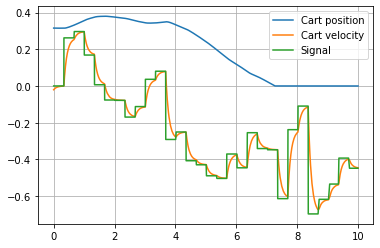

In [16]:
from tensor_ode_solver import *
from crane import *
import numpy as np

_,_,us = randomGaussianWalk(endtime = 100.,drift = 0.,std = 0.3,samples = 300) 
_,_,ls = randomGaussianWalk(endtime = 100.,drift = 0.,std = 0.3,samples = 300) 
out =solve_ivp(dynamic_from_signals(us,ls),(0,10),randomState(),method = "BDF",dense_output=True)
uv = lambda t: out.sol(t)[5]
uvs = np.array([uv(t) for t in out.t])
su = np.array([us(t) for t in out.t])

x = lambda t: out.sol(t)[4]
xs = np.array([x(t) for t in out.t])


plt.plot(out.t, xs/15.,label = "Cart position")
plt.plot(out.t, uvs/UMAX,label ="Cart velocity")
plt.plot(out.t, su,label = "Signal")
plt.grid()
plt.legend()




La rutina de entrenamiento se encuentra en el archivo *tensor_ode_solver.py* en el método *train_from_case* de la clase *Dynamic*. Primero se integra la dinámica generada por la red neuronal hacia adelante en el tiempo, desde $t_0$ a $t_f$ partiendo del estado inicial $y_0$ para llegar a la aproximación del estado final $h(t_f)$. Después se calcula la función de costo $L(y_f,h(t_f))$ ,que en este caso es:
$$L(y_f,h) = \frac{MSE(y_f,h)}{t_f-t_0} $$
Utilizamos esta función de error pues penaliza la tasa de acumulación de error en el tiempo de forma que no privilegia los casos en que el estado inicial y final están muy próximos en el tiempo.
Ahora realizamos retropropagación de las derivadas de esta cantidad para obtener el estado inicial adjunto:

$$a(t_f) = \frac{\partial L}{\partial z}(t_f) \qquad  0 = \frac{\partial L}{\partial \theta}(t_f)$$
Afortunadamente actualizaciones recientes del módulo PyTorch permiten hacer esta retropropagación en *autograd* de forma independiente en cada ronda. Dado que por lo general la retropropagación en Torch se realiza mediante el método *backward* de instancias de la clase *Functional* entonces se espera que en cada llamada al método *backward* se calcula un jacobiano. Sin embargo el método de estados aumentados da las derivadas con respecto a los parámetros de la red por lo que se implementó como un método dentro de la misma clase de la red.

Posterior a esto, podemos definir el estado aumentado, cuya dinámica ya conocemos, y realizar la integración temporal ahora de $t_f$ a $t_0$. Nótese que esto involucra obtener derivadas de la salida de la red $f(z,\theta)$ con respecto a $z$ y $\theta$, y manipularlas matricialmente. Esta no es una operación usual en Torch por lo que adaptamos las funciones de *autograd* para que cumplieran este propósito. La implementación de estos gradientes se encuentra en las funciones *input_jacobian* y *flat_param_jacobian* que calculan el jacobiano con respecto a la entrada de la red y con respecto al vector de parámetros.

Actualizamos los parámetros de la red utilizando la regla de descenso por gradiente con tasa de aprendizaje $\alpha$. En código esto es posible gracias a las funciones *vec_to_parameters* y *parameters_to_vec* que permitieron transformar los parámetros de la red como cantidades ordinarias y después volver a insertarlos como parámetros en la red.

### Resultados del Entrenamiento

Realizamos experimentos con varias arquitecturas. En algunas incorporamos capas del tipo *Bilinear* cuya evaluación es de la forma:
$$ Z(x) = x^T \mathbf{A} x + \vec{b} $$
donde los parámetros son las entradas de la matrix y el vector de sesgo.

Introducimos este tipo de capas ya que sabemos que la dinámica original tiene productos de las variables de estado. En nuestros equipos, el entrenamiento de un solo caso tomaba aproximadamente $9-30$ segundos para una red pequeña con la integración de los estados aumentados siendo la parte más costosa de la rutina. Después de aproximadamente $40-50$ iteraciones las redes aún no presentaban mejoras sustanciales en cuanto a su tarea de reproducir la dinámica original.

Las redes que quedaron al final tienen varias capas lineales con activaciones ReLU y Tanh. La activación Tanh es importante para poder escalar fácilmente las salidas de la red.

Notamos que en general reducían rápidamente el error en la predicción de la posición del carro y la longitud. Esto es predecible pues la dinámica de estas cantidades puede ser puesta en términos de combinaciones lineales de ellas mismas , la señales de control y las respectivas velocidades. También varias redes detectaron rápidamente las fronteras "duras" del riel del carro y la longitud del cable.

Por otra parte las variables angulares son la mayor fuente de error en las predicciones. Incluso en intervalos pequeños de tiempo estas variables diferían significativamente del caso de entrenamiento.

Dada la naturaleza del problema es complicado establecer medidas de rendimiento. Sin embargo si asumimos que cada paso en un algoritmo de integración introduce una cantidad de error constante (promedio) entonces el error acumulado en una integración en un intervalo de tiempo $\tau$ debería ser proporcional a $\tau$. Es decir que esperaríamos que el error MSE entre la predicción y el valor real si el calculo involucra integrar sobre un intervalo $\tau$ de tiempo es:
$$ MSE = C^2 \tau^2  $$ 
la constante $C$ se podría interpretar como la tasa de error promedio introducida por unidad de tiempo por las predicciones de la red. Al calcularla en el entrenamiento la usamos como un indicador del error de la red. Debajo observamos la gráfica de $C^2$ contra el número de iteraciones para la 7° arquitectura que probamos. A pesar de que esta cantidad varía con respecto al caso en promedio dsiminuye con el entrenamiento.

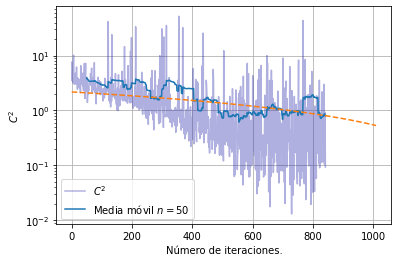

### Bibliografía

[1] Chen, Ricky TQ, et al. _"Neural ordinary differential equations."_ arXiv preprint arXiv:1806.07366 (2018).

[2] Liz Rincon, Yuta Kubota, Gentiane Venture, Yasutaka Tagawa. _Inverse dynamic control via “simulation of feedback control” by artificial neural networks for a crane system_. Control Engineering Practice, Volume 94, 2020,104203,ISSN 0967-0661,
https://doi.org/10.1016/j.conengprac.2019.104203.